<a href="https://colab.research.google.com/github/DANIELVSHVL/DIPLOM/blob/main/Production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Расчет вероятностей для загруженных моделей

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import re
import joblib
from tensorflow.keras.models import load_model

# === Настройка типов моделей
MODEL_TYPES = {
    "К": "rf",
    "П": "rf"
}

# === Пути до моделей
MODEL_PATHS = {
    "mlp": {
        "К": "/content/drive/MyDrive/rzd_diploma/models/mlp_model_kupe_with_meta.h5",
        "П": "/content/drive/MyDrive/rzd_diploma/models/mlp_model_plaz_with_meta.h5"
    },
    "rf": {
        "К": "/content/drive/MyDrive/rzd_diploma/models/rf_model_kupe.joblib",
        "П": "/content/drive/MyDrive/rzd_diploma/models/rf_model_plaz.joblib"
    },
    "cnn": {
        "К": "/content/drive/MyDrive/rzd_diploma/models/cnn_model_kupe.h5",
        "П": "/content/drive/MyDrive/rzd_diploma/models/cnn_model_plaz.h5"
    }
}

# === Загрузка моделей
loaded_models = {}
for wagon_type in ["К", "П"]:
    model_type = MODEL_TYPES[wagon_type]
    model_path = MODEL_PATHS[model_type][wagon_type]
    if model_type in ["mlp", "cnn"]:
        loaded_models[wagon_type] = load_model(model_path)
    elif model_type == "rf":
        loaded_models[wagon_type] = joblib.load(model_path)
    else:
        raise ValueError(f"Неизвестный тип модели: {model_type}")

# === Подготовка путей
prod_path = Path("/content/drive/MyDrive/rzd_diploma/data/prod_data")
output_path = prod_path.parent / "place_probabilities_production.csv"
txt_files = sorted(prod_path.glob("*_production.txt"))

def extract_key(file):
    match = re.match(r"(\d+)([КKП])_production\.txt", file.name)
    if match:
        num = int(match.group(1))
        typ = match.group(2).upper().replace("K", "К")
        return (num, typ)
    return (9999, "Я")

txt_files = sorted(txt_files, key=extract_key)

# === Определение режима загрузки
def occupancy_bin(count: int, wagon_type: str) -> int:
    total_places = 36 if wagon_type == "К" else 54
    ratio = count / total_places
    if ratio <= 1/6: return 1
    elif ratio <= 2/6: return 2
    elif ratio <= 3/6: return 3
    elif ratio <= 4/6: return 4
    elif ratio <= 5/6: return 5
    else: return 6

# === Расчёт вероятностей
def calculate_isolation_score(place: int, vector: list, wagon_type: str) -> float:
    """Вычисляет степень изоляции для заданного места в вагоне."""
    if wagon_type == "К":
        coupe_number = (place - 1) // 4 + 1
        coupe_places = list(range((coupe_number - 1) * 4 + 1, coupe_number * 4 + 1))
        free_neighbors = sum(1 for i in coupe_places if i != place and vector[i - 1] == 0)
        return free_neighbors / 3
    elif wagon_type == "П":
        group_mapping = {
            1: [1, 2, 3, 4, 53, 54],
            2: [5, 6, 7, 8, 51, 52],
            3: [9, 10, 11, 12, 49, 50],
            4: [13, 14, 15, 16, 47, 48],
            5: [17, 18, 19, 20, 45, 46],
            6: [21, 22, 23, 24, 43, 44],
            7: [25, 26, 27, 28, 41, 42],
            8: [29, 30, 31, 32, 39, 40],
            9: [33, 34, 35, 36, 37, 38],
        }
        group_places = [j for group, places in group_mapping.items() if place in places for j in places if j != place]
        free_neighbors = sum(1 for j in group_places if vector[j - 1] == 0)
        return free_neighbors / 5
    return 0.0
def get_place_probabilities(model, model_type, occupied_vector, wagon_type):
    max_len = 36 if wagon_type == "К" else 54
    occupied_places = [i + 1 for i, val in enumerate(occupied_vector[:max_len]) if val == 1]
    count_occupied = len(occupied_places)
    regime = occupancy_bin(count_occupied, wagon_type)

    results = []

    for i in range(1, max_len + 1):
        if i in occupied_places:
            continue

        # === Вектор конфигурации мест
        place_vector = []
        for j in range(1, 55):
            if wagon_type == "К" and j > 36:
                place_vector.append(np.nan)
            elif j == i:
                place_vector.append(-1)
            elif j in occupied_places:
                place_vector.append(1)
            else:
                place_vector.append(0)

        # === Метапризнаки
        нижнее = 1 if i % 2 == 1 else 0
        верхнее = 1 if i % 2 == 0 else 0
        боковушка = 1 if wagon_type == "П" and i >= 37 else 0
        номер_места = i
        номер_группы = (i - 1) // 6 + 1 if wagon_type == "П" else 0
        номер_купе = (i - 1) // 4 + 1 if wagon_type == "К" else 0
        meta_raw = [нижнее, верхнее, боковушка, номер_места, номер_группы, номер_купе, regime]

        # === Расчёт изоляции
        isolation_score = calculate_isolation_score(i, occupied_vector, wagon_type)

        # === Прогноз
        if model_type == "mlp":
            meta = meta_raw.copy()
            meta[3] = (meta[3] - 1) / 53
            meta[4] = (meta[4] - 0) / 8
            meta[5] = (meta[5] - 0) / 8
            meta[6] = (meta[6] - 1) / 5
            input_vector = np.array(place_vector[:max_len] + meta).reshape(1, -1)
            proba = float(model.predict(input_vector, verbose=0)[0][0])

        elif model_type == "rf":
            # === Дополняем до 54 мест
            place_vector_padded = place_vector[:max_len] + [np.nan] * (54 - max_len)
            place_column_names = [f"место_{j}" for j in range(1, 55)]
            all_column_names = place_column_names + [
                "нижнее", "верхнее", "боковушка", "номер_места",
                "номер_группы", "номер_купе", "режим_загрузки"
            ]
            full_input = place_vector_padded + meta_raw
            full_df = pd.DataFrame([full_input], columns=all_column_names)
            proba = float(model.predict_proba(full_df)[0, 1])

        elif model_type == "cnn":
            input_vector = np.array(place_vector[:max_len]).reshape(1, -1)
            proba = float(model.predict(input_vector, verbose=0)[0][0])

        else:
            raise ValueError(f"Неизвестный тип модели: {model_type}")

        # === Коррекция вероятности по изоляции
        proba *= (0.5 + 0.8 * isolation_score)

        results.append({
            "место": i,
            "вероятность": proba
        })

    return results


# === Основной цикл
results_all = []

for file in txt_files:
    match = re.match(r"(\d+)([КKП])_production\.txt", file.name)
    if not match:
        print(f"[Пропущено] Некорректное имя: {file.name}")
        continue

    number = int(match.group(1))
    wagon_type = match.group(2).upper().replace("K", "К")
    wagon_name = f"{number}{wagon_type}_production"

    try:
        with open(file, "r", encoding="utf-8") as f:
            data = f.read()
    except Exception as e:
        print(f"[Ошибка] Не удалось открыть {file.name}: {e}")
        continue

    clean = ''.join(c if c.isdigit() or c in ', \n\r\t' else ' ' for c in data)
    tokens = [x.strip() for x in clean.replace("\n", ",").replace("\r", ",").split(",")]
    occupied = [int(x) for x in tokens if x.isdigit()]

    if not occupied:
        print(f"[Пропущено] Нет занятых мест: {file.name}")
        continue

    # Составление вектора занятости
    vector = []
    for i in range(1, 55):
        if wagon_type == "К" and i > 36:
            vector.append(np.nan)
        else:
            vector.append(1 if i in occupied else 0)

    model = loaded_models[wagon_type]
    model_type = MODEL_TYPES[wagon_type]
    probs = get_place_probabilities(model, model_type, vector, wagon_type)

    for p in probs:
        results_all.append({
            "вагон": wagon_name,
            "тип": wagon_type,
            "место": p["место"],
            "вероятность": p["вероятность"]
        })

# === Сохраняем результаты
recommendations_df = pd.DataFrame(results_all)
recommendations_df.to_csv(output_path, index=False)
print(f"[Готово] Сохранено {len(recommendations_df)} строк в {output_path}")

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- оценка_изоляции


# CV2

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import re

# === Пути по структуре проекта ===
base_path = Path("/content/drive/MyDrive/rzd_diploma")
data_path = base_path / "data"
prod_path = data_path / "prod_data"
proba_path = data_path / "place_probabilities_production.csv"
output_dir = base_path / "visualizations"
output_dir.mkdir(parents=True, exist_ok=True)

# === Цвета и фильтры (HSV) ===
blue_hsv = np.array([105, 126, 255])
gray_hsv = np.array([108, 6, 230])
excluded_hsv = (109, 10, 211)

tolerance_blue = np.array([5, 10, 10])
tolerance_gray = np.array([5, 5, 5])
tolerance_excluded = np.array([0, 0, 5])

# === Загрузка вероятностей по всем вагонам
probs_df_all = pd.read_csv(proba_path)

# === Детекция основных мест (прямоугольников)
def detect_rectangles(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_blue = blue_hsv - tolerance_blue
    upper_blue = blue_hsv + tolerance_blue
    blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

    lower_gray = gray_hsv - tolerance_gray
    upper_gray = gray_hsv + tolerance_gray
    gray_mask = cv2.inRange(hsv_image, lower_gray, upper_gray)

    rectangles = []
    print("\n📦 Начинаем обработку контуров...")

    for mask_name, mask in [("blue", blue_mask), ("gray", gray_mask)]:
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        print(f"🎨 Маска: {mask_name}, найдено контуров: {len(contours)}")

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            rect_hsv = hsv_image[y:y + h, x:x + w]
            avg_hsv = cv2.mean(rect_hsv)[:3]
            avg_hsv_int = tuple(int(v) for v in avg_hsv)

            aspect_ratio = h / w if w != 0 else 0
            reason = ""

            diff = np.abs(np.array(avg_hsv[:3]) - np.array(excluded_hsv))
            if all(diff <= tolerance_excluded):

                reason = "⛔ исключён по цвету"
            elif aspect_ratio < 1.1:
                reason = f"⛔ aspect_ratio {aspect_ratio:.2f} < 1.1"
            elif w <= 10 or h <= 10:
                reason = f"⛔ малый размер {w}x{h}"
            else:
                rectangles.append((x, y, w, h))
                reason = "✅ добавлен"

            print(f"→ [{mask_name}] (x={x:>3}, y={y:>3}, w={w:>2}, h={h:>3}) HSV={avg_hsv_int} → {reason}")

    print(f"🧮 Итого добавлено прямоугольников: {len(rectangles)}\n")
    return rectangles

# === Детекция боковушек для плацкарта
def detect_bokovushki(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_blue = blue_hsv - tolerance_blue
    upper_blue = blue_hsv + tolerance_blue
    blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

    lower_gray = gray_hsv - tolerance_gray
    upper_gray = gray_hsv + tolerance_gray
    gray_mask = cv2.inRange(hsv_image, lower_gray, upper_gray)

    bokovushki = []
    print("📦 Поиск боковушек (места 37–54)...")

    for mask_name, mask in [("blue", blue_mask), ("gray", gray_mask)]:
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            rect_hsv = hsv_image[y:y + h, x:x + w]
            avg_hsv = cv2.mean(rect_hsv)[:3]

            aspect_ratio = h / w if w != 0 else 0
            if aspect_ratio > 1.0:
                continue
            if h < 20 or w < 40:
                continue

            bokovushki.append((x, y, w, h))

    bokovushki_sorted = sorted(bokovushki, key=lambda r: -r[0])
    print(f"🧮 Найдено боковушек: {len(bokovushki_sorted)}")
    return bokovushki_sorted

# === Сортировка прямоугольников по столбцам (купе)
def sort_rectangles(rectangles):
    column_groups = {}
    x_threshold = 15

    for rect in rectangles:
        x, y, w, h = rect
        matched = False
        for key_x in column_groups:
            if abs(x - key_x) <= x_threshold:
                column_groups[key_x].append(rect)
                matched = True
                break
        if not matched:
            column_groups[x] = [rect]

    sorted_columns = sorted(column_groups.items(), key=lambda item: item[0])
    sorted_rectangles = []
    for _, rects_in_col in sorted_columns:
        rects_sorted = sorted(rects_in_col, key=lambda r: -r[1])
        sorted_rectangles.extend(rects_sorted)

    return sorted_rectangles


Найдено изображений: 14
prod_path: /content/drive/MyDrive/rzd_diploma/data/prod_data

📦 Начинаем обработку контуров...
🎨 Маска: blue, найдено контуров: 15
→ [blue] (x=1625, y=135, w=53, h= 96) HSV=(104, 122, 253) → ✅ добавлен
→ [blue] (x=1252, y=135, w=57, h= 96) HSV=(104, 123, 253) → ✅ добавлен
→ [blue] (x=1132, y=135, w=57, h= 96) HSV=(103, 122, 253) → ✅ добавлен
→ [blue] (x=318, y=135, w=57, h= 96) HSV=(104, 124, 253) → ✅ добавлен
→ [blue] (x=198, y=135, w=57, h= 96) HSV=(104, 124, 253) → ✅ добавлен
→ [blue] (x=1505, y=134, w=57, h= 97) HSV=(104, 122, 252) → ✅ добавлен
→ [blue] (x=1625, y=  9, w=53, h=123) HSV=(104, 122, 254) → ✅ добавлен
→ [blue] (x=1505, y=  9, w=57, h=123) HSV=(104, 122, 254) → ✅ добавлен
→ [blue] (x=1438, y=  9, w=57, h=123) HSV=(104, 122, 254) → ✅ добавлен
→ [blue] (x=1252, y=  9, w=57, h=123) HSV=(104, 123, 254) → ✅ добавлен
→ [blue] (x=1132, y=  9, w=57, h=123) HSV=(104, 123, 254) → ✅ добавлен
→ [blue] (x=1065, y=  9, w=57, h=123) HSV=(104, 122, 254) → ✅ доба

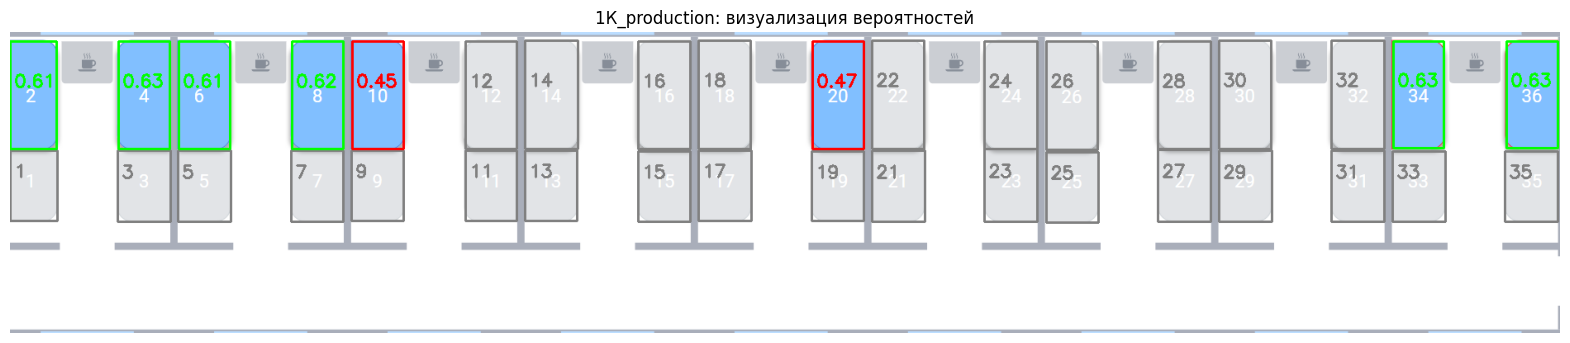

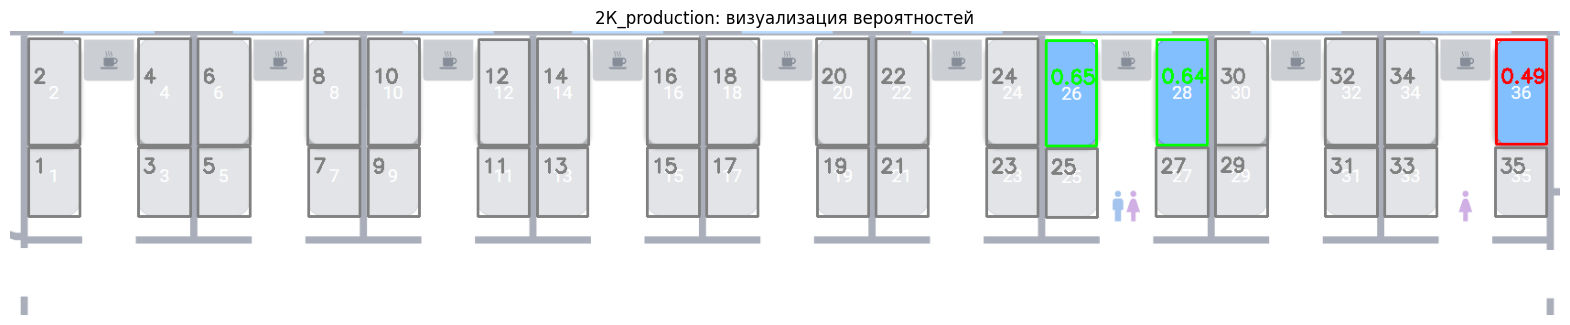

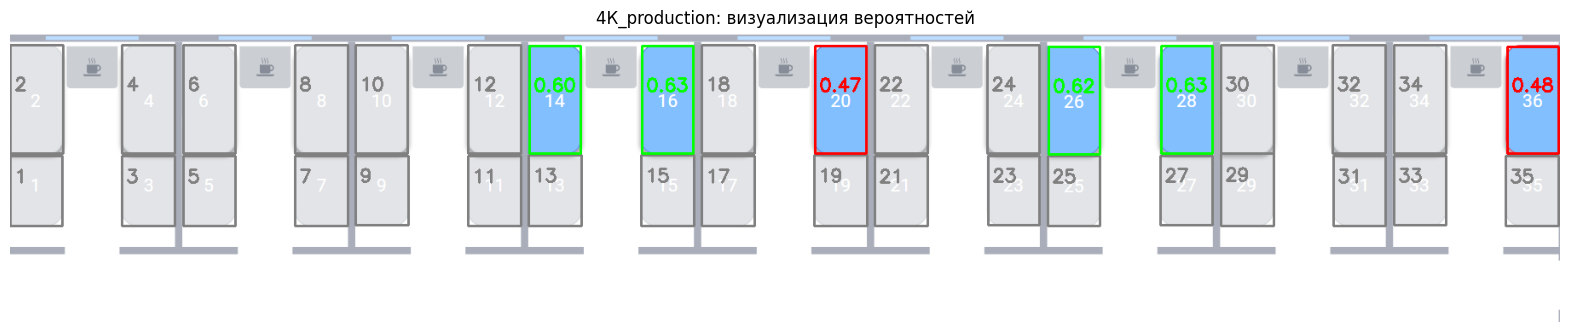

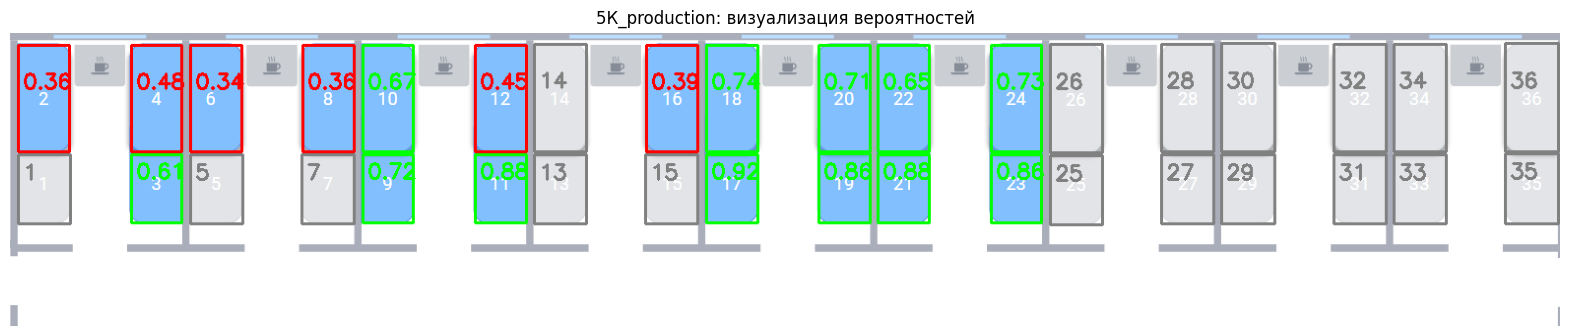

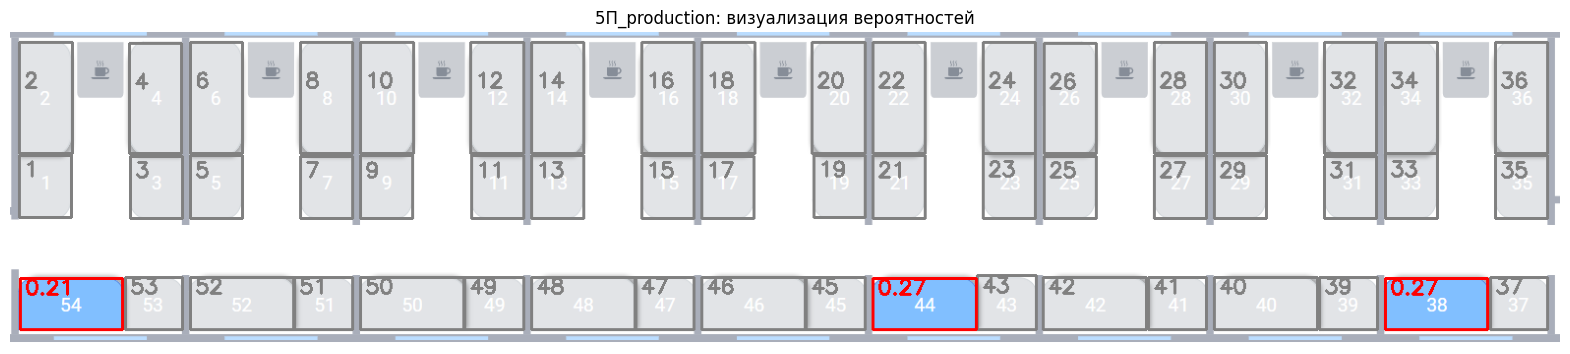

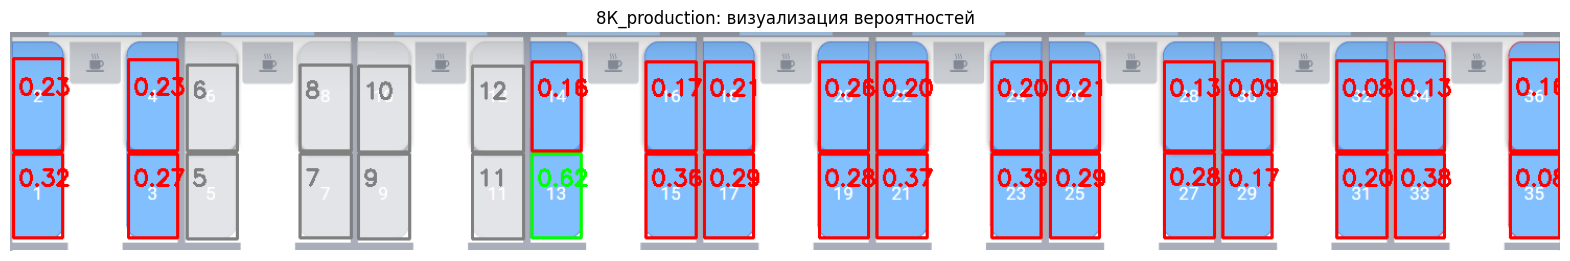

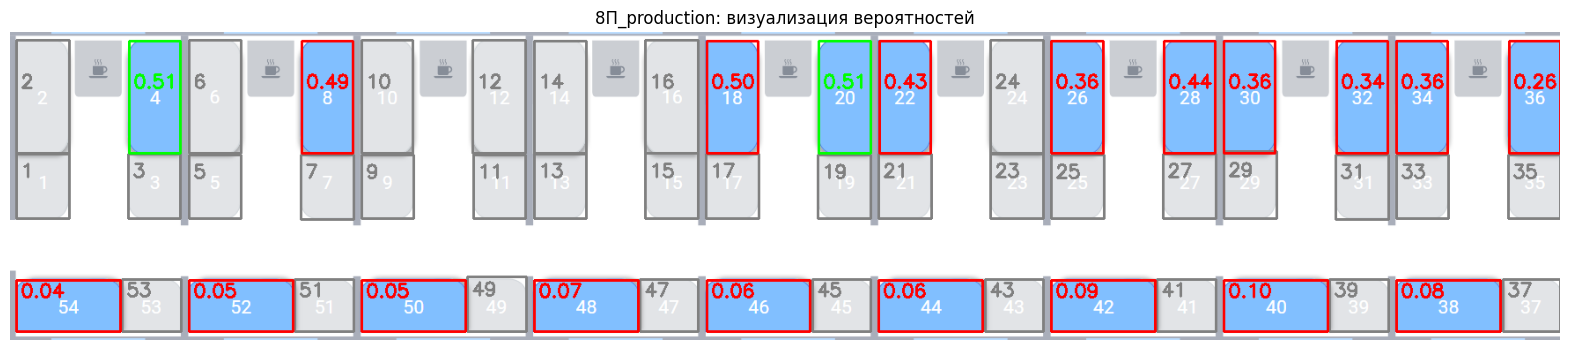

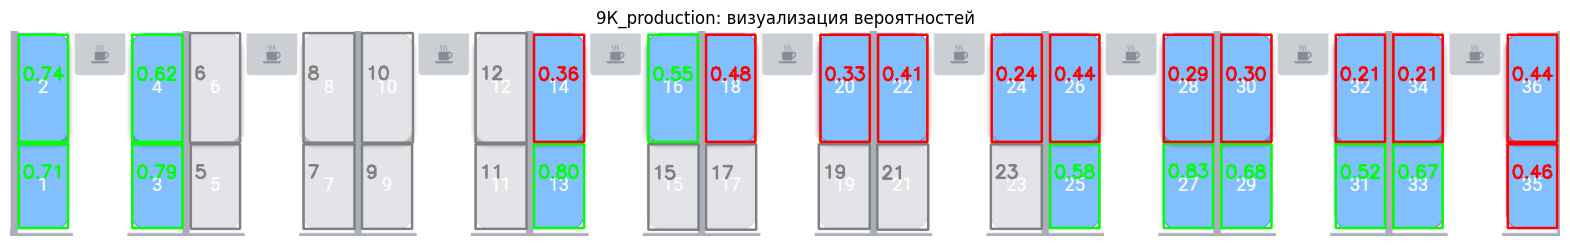

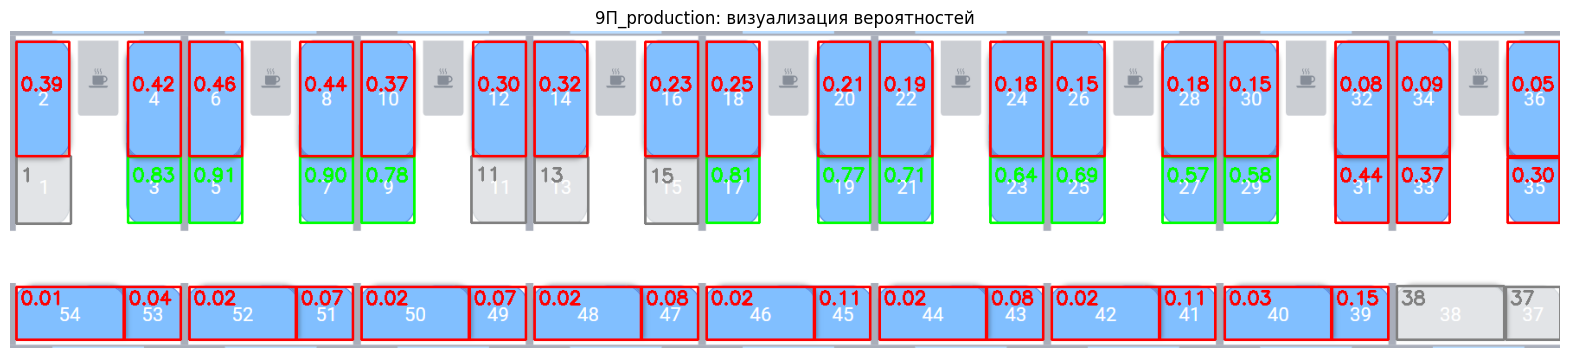

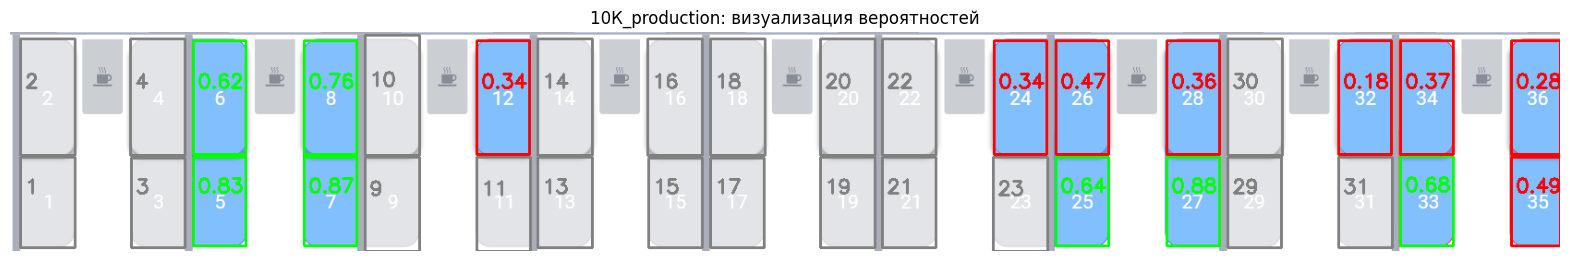

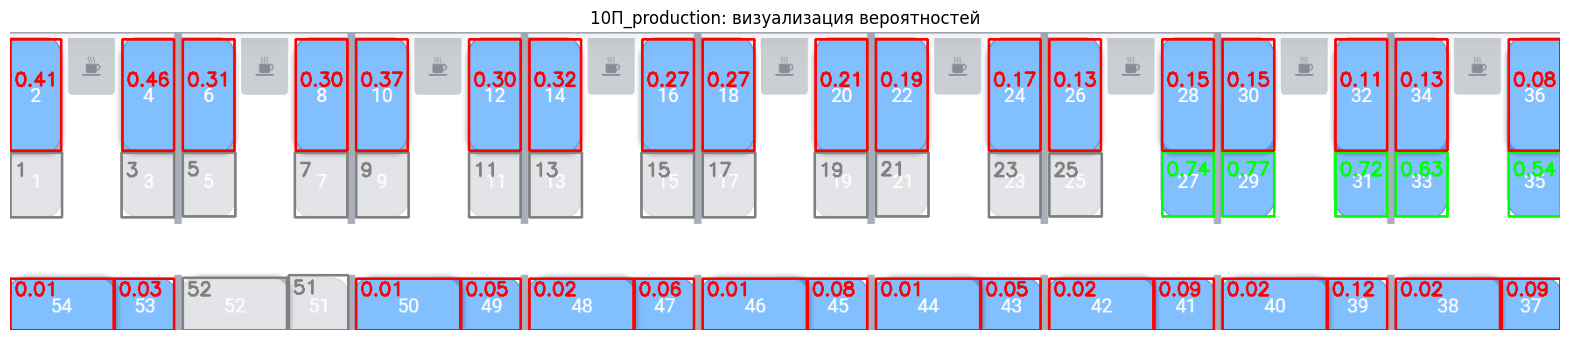

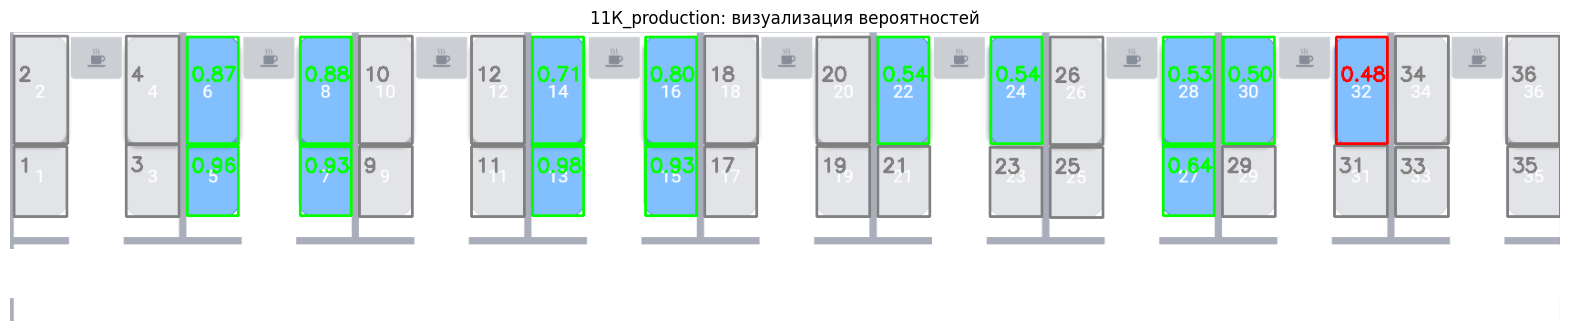

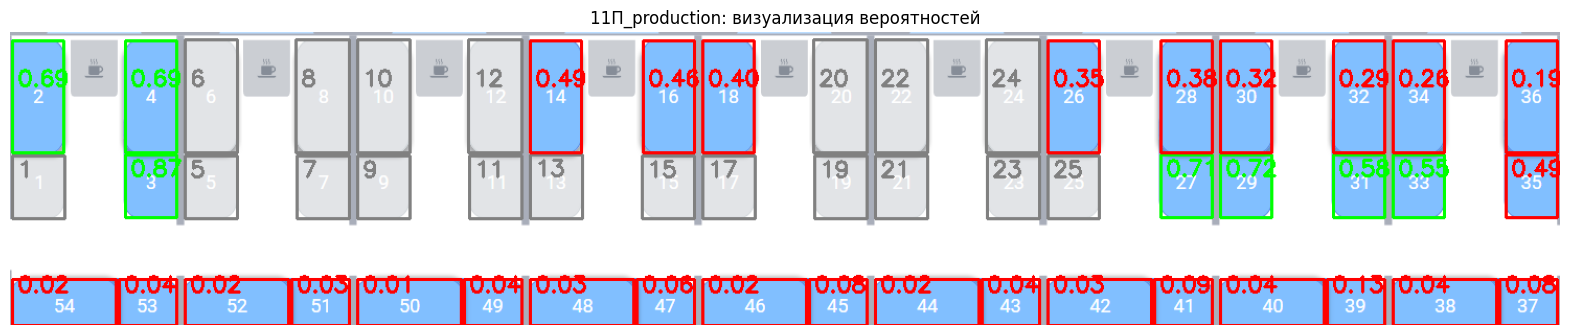

In [ ]:
from pathlib import Path
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Получаем список всех PNG и TXT файлов
all_pngs = sorted([f for f in prod_path.glob("*_production.png")])
all_txts = {f.stem: f for f in prod_path.glob("*_production.txt")}

print(f"Найдено изображений: {len(all_pngs)}")
print(f"prod_path: {prod_path.resolve()}")

saved_images = []

for png_file in all_pngs:
    stem = png_file.stem
    txt_file = all_txts.get(stem)
    if not txt_file:
        print(f"Пропущен {stem}: нет txt-файла")
        continue

    match = re.match(r"(\d+)([КП])_production", stem)
    if not match:
        print(f"Пропущен {stem}: имя не соответствует формату")
        continue
    wagon_type = match.group(2)

    image = cv2.imread(str(png_file))
    if image is None:
        print(f"Не удалось загрузить изображение: {png_file}")
        continue
    visual_image = image.copy()

    try:
        with open(txt_file, "r", encoding="utf-8") as f:
            data = f.read()
        clean = ''.join(c if c.isdigit() or c in ', \n\r\t' else ' ' for c in data)
        tokens = [x.strip() for x in clean.replace("\n", ",").replace("\r", ",").split(",")]
        occupied_places = [int(x) for x in tokens if x.isdigit()]
    except Exception as e:
        print(f"Ошибка чтения {txt_file.name}: {e}")
        continue

    probs_df = probs_df_all[probs_df_all["вагон"] == stem]
    if probs_df.empty:
        print(f"Нет вероятностей для {stem}, пропущен")
        continue

    upper_lower = detect_rectangles(image)
    bokovushki = detect_bokovushki(image) if wagon_type == "П" else []

    sorted_rects = sort_rectangles(upper_lower)
    if bokovushki:
        sorted_rects += bokovushki

    print(f"{stem}: всего мест: {len(sorted_rects)}")

    rect_mapping = []
    for idx, (x, y, w, h) in enumerate(sorted_rects, 1):
        place_number = idx
        if place_number in occupied_places:
            label = str(place_number)
            color = (128, 128, 128)
        else:
            row = probs_df[probs_df["место"] == place_number]
            if not row.empty:
                prob = float(row["вероятность"].values[0])
                label = f"{prob:.2f}"
                color = (0, 255, 0) if prob >= 0.5 else (0, 0, 255)
                rect_mapping.append({
                    "вагон": stem,
                    "номер_прямоугольника": idx,
                    "номер_места": place_number,
                    "вероятность": prob
                })
            else:
                label = "?"
                color = (255, 255, 0)

        cv2.rectangle(visual_image, (x, y), (x + w, y + h), color, 2)
        cv2.putText(visual_image, label, (x + 5, y + h // 2 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    if rect_mapping:
        df_rect = pd.DataFrame(rect_mapping)
        csv_path = output_dir / f"rect_probs_{stem}.csv"
        df_rect.to_csv(csv_path, index=False)

    vis_path = output_dir / f"{stem}_vis.png"
    cv2.imwrite(str(vis_path), visual_image)
    saved_images.append((stem, vis_path))
    print(f"Сохранено: {vis_path.name}")

# Отдельная визуализация: сначала все CSV, затем все скрины
for stem, vis_path in sorted(saved_images, key=lambda x: int(re.search(r"\d+", x[0]).group(0))):
    image = cv2.imread(str(vis_path))
    if image is not None:
        plt.figure(figsize=(20, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"{stem}: визуализация вероятностей")
        plt.show()
